<div style="text-align: center;">
# マクロ経済特論A
<div style="text-align: center;">
第2回：「2期間モデルと数値計算の概観」
<br>
<br>
<div style="text-align: center;">    
2021年11月
<div style="text-align: center;">   
一橋大学　砂川武貴

# 何がどこで必要なのかを理解しよう

- シンプルな2期間モデルを用いて、数値計算手法の基本的な使い方を説明


- Judd (1998) Numerical Methods in Economics
    - 第4章：最適化(optimization)
    - 第5章：非線形方程式(nonlinear equations)の解法
    - 第6章：関数の近似法(approximation methods)
    - 第7章：数値積分と数値微分(numerical integral and differentiation)


- 今回は、実際にモデルを解きながら、各ツールに関する知識が「どこで、なぜ必要になってくるのか」について解説

# ベンチマークモデルとカリブレーション
## 2期間モデル

- ある経済主体の人生全体での消費・貯蓄行動をモデル化

- 前半：若年期（第1期）、後半：老年期（第2期）

- 若年期には働いて所得$w$を稼得、今期の消費$c_{1}$にあてるか、老後のための貯蓄$a$として取っておく


$$
  c_{1} + a = w \tag{1}
$$

- 老年期には働くことはできないため、若年期に蓄積した資産で生活。貯蓄した資産には$r$の金利がつく


- 第2期に経済主体は必ず死亡し、遺産動機はない：全財産を消費に回す

$$
  c_{2} = (1+r)a \tag{2}
$$

- 経済主体は人生全体の効用を最大化するように消費と貯蓄を選択する

$$
  U(c_1,c_2) = u(c_1) + \beta u(c_2)
$$

$\beta$は割引因子(discount factor)と呼ばれる

- $u'(c)>0$及び$u''(c)<0$を満たす場合、経済主体は消費の平準化(consumption smoothing)を望み、以下のオイラー方程式(Euler equation)を満たすように消費を決定する

$$
  u'(c_1) = (1+r)\beta u'(c_2) \tag{3}
$$

- このシンプルな2期間モデルをどうやって解けば良いのであろうか？

- モデルを「解く」＝以下の貯蓄関数を導出

$$
  a = g(w)
$$

## カリブレーション

- 効用関数を「特定化」：相対的危険回避度一定(constant relative risk aversion, CRRA)型効用関数

$$
  u(c) = \frac{c^{1-\gamma}-1}{1-\gamma}
$$

- $1/\gamma$は異時点間の代替の弾力性(intertemporal elasticity of substitution)

- $\gamma \rightarrow 1$のとき、ロピタルの法則(L'Hopital's rule)より、$u(c)=\ln(c)$

In [3]:
%%file CRRA.m
function util = CRRA(cons, gamma)

if gamma ~= 1
%     util = cons.^(1-gamma)./(1-gamma);
    util = (cons.^(1-gamma)-1)./(1-gamma);
else
    util = log(cons);
end

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\CRRA.m'.


- カリブレーション(calibration)：関数形を特定化してパラメータを定める一連の作業
    - モデル上の1期間は30年。そのため、割引因子$\beta$と金利$r$は年率ではなく30年間の値(Song et al., 2012)
    - $\beta=0.985^{30}$
    - $1+r=1.025^{30}$
    - $\gamma=2$

In [2]:
% グローバル変数：obj_two_period.m, obj_projection.mと変数を共有
global w grid_w beta gamma rent

%% *** カリブレーション ***
beta  = 0.985.^30;     % 割引因子
gamma = 2.0;           % 相対的危険回避度
rent  = 1.025.^30-1.0; % 純利子率

## 解析的解の性質

- 2期間モデルの解析的解(closed-form solution)は、この場合手計算で導出できる

$$
  a = \frac{w}{1+(1+r)\{\beta(1+r)\}^{-1/\gamma}} \tag{4}
$$

# 離散近似とグリッド

- 貯蓄関数$a=g(w)$において、所得$w$も資産$a$も連続(continuum)


- コンピュータは連続という概念をそのままの形では理解できないため、変数を離散化(discretize)して考える

## グリッド上で計算する

- 若年期の所得$w$が取り得る値：$w_{i}\in\{w_1,\dots,w_{I}\}$

- この点の集まり：グリッド(grid)あるいはノード(node)

- それぞれの点：グリッドポイント(grid point)あるいは評価点(evaluation point)

- $w$を$\{w_{i}\}_{i=1}^{I}, I=10$個のグリッドで近似

$$
  w_{i} \in \{0.1,0.2,0.3,\dots,1.0\}
$$

添え字の$i$はグリッドの何番目の要素かを表している

$w=0$を含めないことに注意

## 状態変数と操作変数が共に離散の場合

- ここでは、状態変数(state variable)：$w$、操作変数(control variable)：$a$


- $a$についても離散化する：$a$を$\{a_{j}\}_{j=1}^{J}, J=40$個のグリッドで近似

$$
  a_{j} \in \{0.025,0.05,0.075,0.1,\dots,1.0\}
$$

In [4]:
% *** パラメータ ***
nw    =  10;   % 所得グリッドの数
w_max = 1.0;   % 所得グリッドの最大値
w_min = 0.1;   % 所得グリッドの最小値
na    =  400;   % 貯蓄グリッドの数
a_max = 1.0;   % 貯蓄グリッドの最大値
a_min = 0.025; % 貯蓄グリッドの最小値

In [8]:
%% グリッドポイントを計算
grid_w = linspace(w_min, w_max, nw)';
grid_a = linspace(a_min, a_max, na)';

- 経済主体の生涯にわたる効用最大化問題は、各$w_{i}$について、

$$
  \max_{a_{j}\in\{a_{1},\dots,a_{J}\}} \frac{[w_{i}-a_{j}]^{1-\gamma}}{1-\gamma}+\beta\frac{[(1+r)a_{j}]^{1-\gamma}}{1-\gamma}
$$

パラメータ$(\beta,r,\gamma)$についてはすでに値が定まっているので、$w_{i}$が与えられれば$a_{j}$も定まる

- 組み合わせの可能性は、$10\times40=400$通り。それぞれの$w_{i}$ごとに、40種類の$a_{j}$のどれが生涯効用を最大にするのかを「総当り」で計算

In [9]:
%% あらゆる(w,a)の組み合わせについて生涯効用を計算
obj = zeros(na, nw);

for i = 1:nw
    for j = 1:na
        cons = grid_w(i) - grid_a(j);
        if cons > 0.0
            obj(j, i) = CRRA(cons, gamma) + beta*CRRA((1.0+rent)*grid_a(j), gamma);
        else
            % 消費が負値の場合、ペナルティを与えてその値が選ばれないようにする
            obj(j, i) = -10000.0;
        end
    end
end

- 図1(a)：若年期の所得が、$w_{i}=0.5,0.8,1.0$のそれぞれの場合に、老年期のための貯蓄が$a_{j}\in\{0.025,\dots,1.0\}$の値を取ったら生涯効用がいくらになるのかを計算

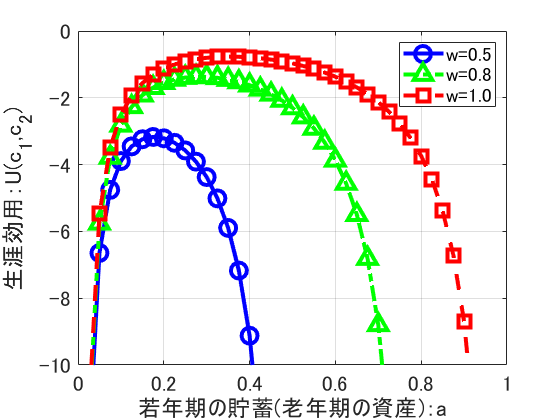

In [6]:
%% 図を描く
figure;
plot(grid_a,obj(:, 5), '-o', 'color', 'blue', 'MarkerEdgeColor', 'b', 'MarkerSize', 12, 'linewidth', 3); hold('on');
plot(grid_a,obj(:, 8), '-.^', 'color', 'green', 'MarkerEdgeColor', 'g', 'MarkerSize', 12, 'linewidth', 3);
plot(grid_a,obj(:, 10), '--s', 'color', 'red', 'MarkerEdgeColor', 'r', 'MarkerSize', 12, 'linewidth', 3); hold('off');
xlabel('若年期の貯蓄(老年期の資産)：a', 'Fontsize', 16);
ylabel('生涯効用：U(c_{1},c_{2})', 'Fontsize', 16);
xlim([0.0, a_max]);
ylim([-10.0, 0.0]);
set(gca,'Fontsize', 16);
legend('w=0.5', 'w=0.8', 'w=1.0', 'Location', 'NorthEast');
grid on;

- $(w_{i},a_{j})$について全てのケースを計算したあと、MATLABであれば、max関数を用いて生涯効用の最大値の値と場所を探す

In [10]:
%% 効用を最大にする操作変数を探し出す：政策関数
pol = zeros(nw,1);

% 各wについて生涯効用を最大にするaを探す
for i = 1:nw
    [maxv, maxl] = max(obj(:,i));
    pol(i) = grid_a(maxl);
end

disp([pol(5) pol(8) pol(10)])

    0.1765    0.2840    0.3549




- 図1(b)：若年期の所得$w_{i}$ごとに最適な貯蓄$a_{j}$を計算してつなげていった組み合わせ＝2期間モデルにおける貯蓄関数

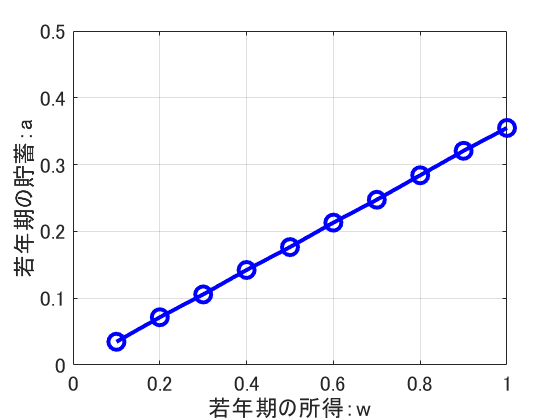

In [11]:
figure;
plot(grid_w,pol, '-o', 'color', 'blue', 'MarkerEdgeColor', 'b', 'MarkerSize', 12, 'linewidth', 3);
xlabel('若年期の所得：w', 'Fontsize', 16);
ylabel('若年期の貯蓄：a', 'Fontsize', 16);
xlim([0, 1]);
ylim([0, 0.5]);
set(gca, 'Fontsize', 16);
grid on;

- 原始的で単純過ぎるように感じるかもしれないが、実は複雑な非線形モデルにも使えるため侮れない


- ただし、計算時間がかかる：状態変数の数が2種類になると、グリッドポイントの数は2倍ではなく2乗（例えば、$10^2=100$通り）。3種類になると$10^3=1000$通り


- この性質を次元の呪い(curse of dimensionality)と呼ぶ。状態変数を増やすほど計算時間は指数的に増えていく

# 操作変数を連続変数にする：最適化

- 状態変数と操作変数をともに離散化するアプローチは、離散化するグリッドの数を節約すると精度が非常に悪くなる


- 本来の解である(4)式は線形であるはずなのに、$J=40$のときの貯蓄関数は直線ではない


- そこで、もう少し洗練されたアプローチを考える：状態変数は離散化するが、操作変数については連続的な値をとる

- 経済主体の最適化問題は、各$w_{i}$ for $i=1,\dots,I$について、

$$
  \max_{a} \frac{[w_{i}-a]^{1-\gamma}}{1-\gamma}+\beta\frac{[(1+r)-a]^{1-\gamma}}{1-\gamma} \tag{6}
$$

となるが、操作変数$a\in\mathbb{R}$については任意の実数をとりうる

In [9]:
%%file obj_two_period.m
function value = obj_two_period(a)

global w beta gamma rent

% 1期の効用水準
if w - a > 0.0
    util_y = CRRA(w - a, gamma); 
else
    % 消費が負値の場合、ペナルティを与えてその値が選ばれないようにする
    util_y = -1000000.0;
end

% 2期の効用水準
util_o = beta*CRRA((1.0+rent)*a, gamma);

% fminbndとfminsearchは共に"最小値"を探すため、マイナスをかけて反転させる
value = -1.0*(util_y + util_o);

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\obj_two_period.m'.


- どうやって(6)式の解を得ればよいのであろうか？


- とりあえず、最適化(optimization)と呼ばれるライブラリを使う
    - MATLABであれば、Optimization Toolboxにある関数fminsearchやfminbnd
    - Pythonであれば、SciPyにある関数fmin
    - Juliaであれば、Optim.jlにある関数

- アルゴリズム


1. パラメータを設定する（カリブレーション）。

2. $w_{i}\in\{w_{1},\dots,w_{I}\}$を離散化した若年期の所得とする。

3. 各$w_{i}$について、(6)式を最大にするような$a$を探し出す。各言語の最適化関数を利用する。

4. 得られた各$w_{i}$と$a$の組み合わせが貯蓄関数である。

In [10]:
%% fminbnd(最適化関数の一つ)を使って効用最大化問題を解く
a_gs = zeros(nw,1);

% 各wについて目的関数(obj_two_period.mを最大にするaを探す)
for i = 1:nw
    w = grid_w(i);
    % w*0.01とw*2.0は探す区間の範囲：詳細は"help fminbnd"
    [a_gs(i), fval] = fminbnd(@obj_two_period, w*0.01, w*2.0);
end

In [11]:
%% fminsearch(最適化関数の一つ)を使って効用最大化問題を解く
a_ss = zeros(nw,1);

for i = 1:nw
    w = grid_w(i);
    % 0.0は初期値：詳細は"help fminsearch"
    [a_ss(i), fval] = fminsearch(@obj_two_period, 0.0);
end

- 図2は、MATLABの最適化関数fminsearch, fminbndを使って、各$w_{i}$における最適な$a$を探してプロットした貯蓄関数。操作変数が取りうる値を連続にすることで、計算精度が大幅に改善された。

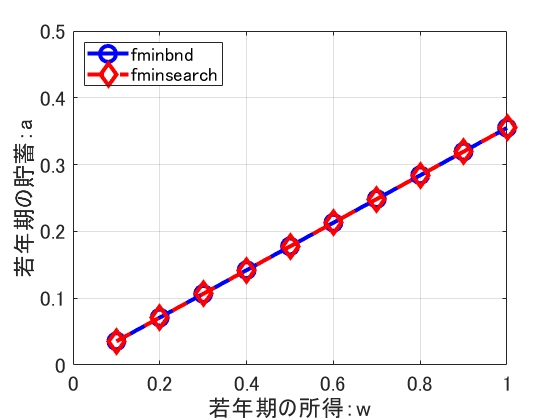

In [12]:
%% 図を描く
figure;
plot(grid_w, a_gs, '-o', 'color', 'blue', 'MarkerEdgeColor', 'b', 'MarkerSize', 12, 'linewidth', 3); hold('on');
plot(grid_w, a_ss, '--d', 'color', 'red', 'MarkerEdgeColor', 'r', 'MarkerSize', 12, 'linewidth', 3); hold('off');
xlabel('若年期の所得：w', 'Fontsize', 16);
ylabel('若年期の貯蓄：a', 'Fontsize', 16);
xlim([0, w_max]);
ylim([0, 0.5]);
legend('fminbnd','fminsearch','Location','NorthWest');
set(gca, 'Fontsize', 16);
grid on;

# 一階条件を使う：求根アルゴリズム

## 非線形方程式のゼロ点を探す

- 予算制約を代入した後の2期間モデルの一階条件(3)は、

$$
  u'(w-a) = (1+r)\beta u'((1+r)a) \tag{7}
$$

となる（オイラー方程式）。

- 前節と同様に、$w_{i}$については離散化して考えると、

$$
  u'(w_{i}-a) = (1+r)\beta u'((1+r)a)
$$

なので、未知の変数は$a$のみである。

- (7)式を、

$$
  R(w_{i}) = (1+r)\beta \frac{u'((1+r)a)}{u'(w_{i}-a)} -1 \tag{8}
$$

と書き換えると、ある$w_{i}$のもとで$R(w_{i}) =0$となるような$a$、すなわち残差関数(residual function)のゼロ点を探す問題(root-finding problem：求根問題)に読み替えることができる。

- 残差関数は複雑の形をした非線形方程式の可能性


- 非線形方程式のゼロ点を探す手法に関する研究は長い歴史を持つため、既に様々なアプローチが存在
    - MATLABであれば、fzero
    - Pythonであれば、SciPyにある関数fsolve
    - Juliaであれば、Optim.jlにある関数

- アルゴリズム


1. パラメータを設定する（カリブレーション）。

2. $w_{i}\in\{w_{1},\dots,w_{I}\}$を離散化した若年期の所得とする。

3. 各$w_{i}$について、(8)式がゼロになる$a$を探し出す。ゼロ点を探すためには、各言語に備わっている（あるいは外部ライブラリの）求根アルゴリズムを利用する。

4. 得られた各$w_{i}$と$a$の組み合わせが貯蓄関数である。

In [13]:
%%file mu_CRRA.m
function mu = mu_CRRA(cons, gamma)

mu = cons.^-gamma;

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\mu_CRRA.m'.


In [14]:
%%file resid_two_period.m
function resid = resid_two_period(a)

global w beta gamma rent

% 1期の限界効用
if w - a > 0.0
    mu1 = mu_CRRA(w - a, gamma);
else
    % 消費が負値の場合、ペナルティを与えてその値が選ばれないようにする
    mu1 = 10000.0;
end

% 2期の限界効用
mu2 = mu_CRRA((1.0+rent)*a, gamma);

% 残差
resid = beta*(1.0+rent)*(mu2/mu1) - 1.0;

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\resid_two_period.m'.


In [15]:
%% 残差をプロットしてみる(最終的な結果には不要な計算)：図3
resid1 = zeros(na, 1);
resid2 = zeros(na, 1);
resid3 = zeros(na, 1);

% w = 0.5
w = 0.5;
for i = 1:na
    resid1(i) = resid_two_period(grid_a(i));
end

% w = 0.8
w = 0.8;
for i = 1:na
    resid2(i) = resid_two_period(grid_a(i));
end

% w = 1.0
w = 1.0;
for i = 1:na
    resid3(i) = resid_two_period(grid_a(i));
end

grid_zero = zeros(na,1);

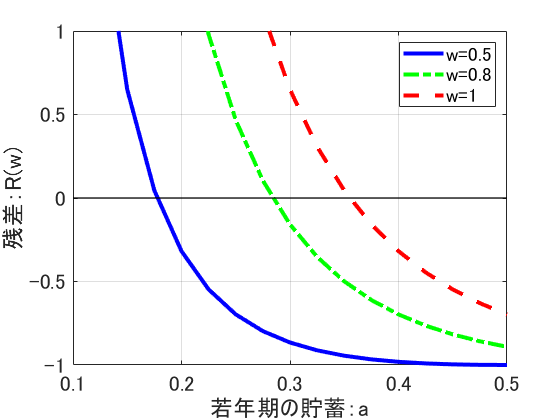

In [16]:
figure;
plot(grid_a, resid1, '-', 'color', 'blue', 'MarkerEdgeColor', 'b', 'MarkerSize', 12, 'linewidth', 3); hold('on');
plot(grid_a, resid2, '-.', 'color', 'green', 'MarkerEdgeColor', 'g', 'MarkerSize', 12, 'linewidth', 3);
plot(grid_a, resid3, '--', 'color', 'red', 'MarkerEdgeColor', 'r', 'MarkerSize', 12, 'linewidth', 3);
plot(grid_a, grid_zero,'-', 'color', 'black', 'linewidth', 1); hold('off');
xlabel('若年期の貯蓄：a', 'Fontsize', 16);
ylabel('残差：R(w)', 'Fontsize', 16);
xlim([0.1, 0.5]);
ylim([-1, 1]);
legend('w=0.5', 'w=0.8', 'w=1', 'Location', 'NorthEast');
set(gca,'Fontsize', 16);
grid on;

In [17]:
%% 非線形関数の根を探す関数を用いて残差をゼロにするaを探す
a_nl = zeros(nw,1);

for i = 1:nw
    w = grid_w(i);
    % 0.1は初期値：詳細は"help fzero"
    a_nl(i) = fzero(@resid_two_period, 0.01);
end

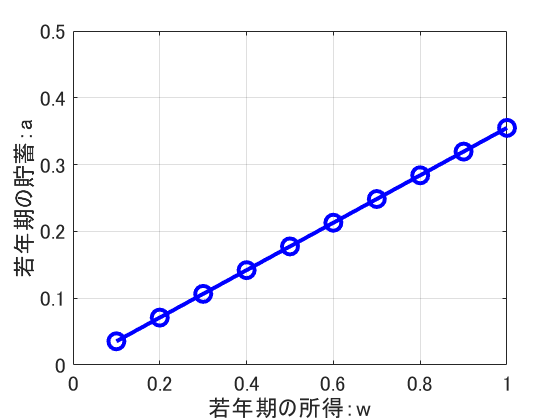

In [18]:
%% 図を描く
figure;
plot(grid_w, a_nl, '-o', 'color', 'blue', 'MarkerEdgeColor', 'b', 'MarkerSize', 12, 'linewidth', 3);
xlabel('若年期の所得：w', 'Fontsize', 16);
ylabel('若年期の貯蓄：a', 'Fontsize', 16);
xlim([0, w_max]);
ylim([0, 0.5]);
set(gca, 'Fontsize', 16);
grid on;

## 射影法

- 最適化と求根アルゴリズムを使った手法は、現在の資産水準を離散個に区切って、そのうえでの最適貯蓄を計算するという点で共通している


- それに対して射影法(projection method)では、政策関数全体を近似する

- 例えば、貯蓄関数を$N$次の多項式(polynomials)

$$
  \hat{g}(w;\mathbb{\theta}) = \sum_{n=0}^{N} \theta_{n}w^{n} \tag{9}
$$

で近似したいとしよう


- (4)式から、$a=\theta_{1}w$の形式で表現できることがここでは分かっている

- しかし、一般的には政策関数はより複雑な形状をしている


- 射影法は、オイラー方程式を満たす政策関数を探すという問題を、多項式における未知の係数ベクトル$\mathbb{\theta}=\{\theta_{n}\}_{n=0}^{N}$を探す問題に置き換える


- より一般的には、多項式は

$$
  \hat{g}(w;\mathbb{\theta}) = \sum_{n=0}^{N} \theta_{n}\Psi_{n}(w)
$$

と書くことが出来る。このとき、$\Psi_{n}(w)$は基底関数(basis function)と呼ばれる。

- (9)式が真の政策関数をうまく近似しているのであれば、この式を(8)式の残差関数に代入した場合の残差はゼロに近いはずである。すなわち、

$$
  R(w;\mathbb{\theta}) = \beta(1+r) \frac{u'((1+r)\hat{g}(w;\mathbb{\theta}))}{u'(w-\hat{g}(w;\mathbb{\theta}))} -1 = 0
$$

が「あらゆる$w$」で成立している必要がある


- 実際には、$R(w;\mathbb{\theta})$が「十分に」ゼロに近ければよい

- 距離関数$\rho$(metric fuction)を導入すると、政策関数を探す問題は、

$$
  \hat{\mathbb{\theta}} = \text{arg}\min_{\theta}\rho(R(w;\mathbb{\theta}),0)
$$

を探す問題に置き換えることができる


- ここでは任意の評価点を取って、そこでの残差（の絶対値）がゼロに近くなる係数ベクトル$\theta$を探す。これを選点法(collocation method)と呼ぶ

<!--
$$
  \rho(R(w;\mathbb{\theta}),0) = \sum_{i=1}^{I}|R(w_{i};\mathbb{\theta})|
$$
-->

- アルゴリズム


1. パラメータを設定する（カリブレーション）。

2. 選点(collocation)$w_{i}\in\{w_{1},\dots,w_{I}\}$を定める。今回はこれまでと同じく$w_{i} \in \{0.1,0.2,0.3,\dots,1.0\}$とする。

3. 近似したい政策関数の関数形を定める。今回は1次関数$\hat{g}(w;\mathbb{\theta}) = \theta_{0} + \theta_{1}w$とする。

4. $\{\theta_{0},\theta_{1}\}$をインプットとして、選点上の残差$R(w_{i},\mathbb{\theta})$を計算して返すサブルーチンを書く(resid_projection.m)。

5. *距離関数を最小化*する$\{\theta_{0}^{*},\theta_{1}^{*}\}$を見つける。

6. 得られた$\hat{g}(w;\mathbb{\theta}^{*}) = \theta_{0}^{*} + \theta_{1}^{*}w$が貯蓄関数である。

<!--5. 残差関数が十分にゼロに近くなる$\{\theta_{0}^{*},\theta_{1}^{*}\}$を見つける。-->

In [19]:
%%file resid_projection.m
function resid = resid_projection(coef)

global grid_w beta gamma rent

% 係数thetaを使って政策関数を計算
a = coef(1) + coef(2)*grid_w;

% 各wにおける1期の消費水準を計算
c1 = grid_w - a;

[r,c] = size(c1);
ng    = max(r,c);

% 1期における限界効用
mu1 = zeros(ng,1);
for i = 1:ng
    if c1(i) > 0.0
        mu1(i) = mu_CRRA(c1(i), gamma);
    else
        % 消費が負値の場合、ペナルティを与えてその値が選ばれないようにする
        mu1(i) = 10000.0;
    end
end

% 2期の消費水準
c2 = (1.0+rent).*a;

% 2期における限界効用
mu2 = zeros(ng,1);
for i = 1:ng
    if c2(i) > 0.0
        mu2(i) = mu_CRRA(c2(i), gamma);
    else
        mu2(i) = 10000.0;
    end
end

% 残差
resid = beta*(1.0+rent)*(mu2./mu1) - 1.0;
% （残差の絶対値の総和を最小化）
resid = sum(abs(resid));

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\resid_projection.m'.


In [20]:
% 係数の初期値を当て推量(initial guess)
coef_ini = [0.1, 0.35];
% fminsearchを使って、選点上で残差がゼロに近くなる係数thetaを探す
coef = fminsearch(@resid_projection, coef_ini);
coef(1)
coef(2)


ans =

   8.8310e-07


ans =

    0.3550




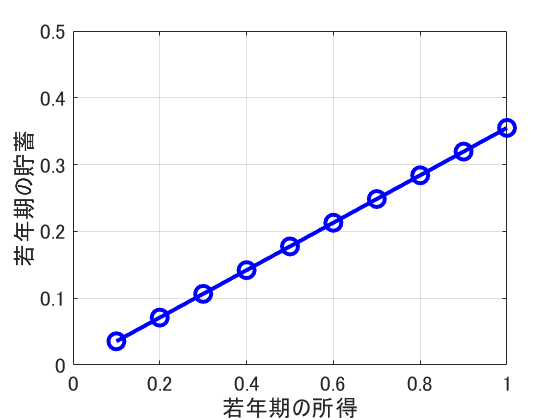

In [21]:
%% 図を描く
% fminsearchを使って得た"coef"を使って政策関数を計算
%next_a = approx_policy(coef, grid_w);
next_a = coef(1) + coef(2)*grid_w;
figure;
plot(grid_w,next_a,'-o','color','blue','MarkerEdgeColor','b','MarkerSize',12,'linewidth',3);
xlabel('若年期の所得','Fontsize',16);
ylabel('若年期の貯蓄','Fontsize',16);
xlim([0,w_max]);
ylim([0,0.5]);
set(gca,'Fontsize',16);
grid on;